### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy.stats import norm
import pywt
from aeon.classification.distance_based import ElasticEnsemble, ShapeDTW, KNeighborsTimeSeriesClassifier
from sklearn.linear_model import RidgeClassifierCV
from aeon.datasets import load_classification
from aeon.datasets.tsc_data_lists import univariate_equal_length
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
import timeit
from datetime import timedelta
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings("ignore")

In [20]:
dataset_list = ['Adiac', 'Beef', 'Car', 'CBF', 'Coffee', 'DiatomSizeReduction', 'ECG200', 'ECGFiveDays', 'FaceFour',
'GunPoint', 'Lightning2', 'Lightning7', 'MoteStrain', 'OliveOil', 'SonyAIBORobotSurface1','SonyAIBORobotSurface2', 'SyntheticControl']
#'MedicalImages', 'Trace', 'TwoPatterns'
# Para cada conjunto de dados na lista
total_time = 0
algos = ['1nn', '3nn', 'svm', 'nb', 'gbc', 'ee', 'shape', 'rf', 'rd']
for dataset_name in dataset_list:
    # Carregue os dados de treinamento e teste
    X_train, y_train = load_classification(dataset_name, extract_path="./Temp/", split="TRAIN")
    X_test, y_test = load_classification(dataset_name, extract_path="./Temp/", split="test")
    
    # Achatando os dados para 2D, pois alguns algoritmos esperam 2D
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    dataset_accuracies = []
    # Para cada algoritmo
    for algo in algos:
    # Treinar o modelo e fazer previsões
        start = timeit.default_timer()
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train_flat, y_train, base_option='svm', meta_option='rf')
        predictions_test_meta = predict_with_meta_classifier(X_test_flat, trained_base_models, meta_classifier)
        stop = timeit.default_timer()
        total_time += stop - start
        real_time = str(timedelta(seconds=total_time))
        
        # Calcular a acurácia e armazená-la
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        dataset_accuracies.append(test_accuracy_meta)
        
        
        print(f"Acurácia do modelo {algo} para {dataset_name}: {test_accuracy_meta}")
        print('Time runtime (seconds): ', real_time)
        
np.savetxt("Results_MSLOO_.csv", dataset_accuracies, delimiter=",")

Testing Instances: 100%|##########| 391/391 [00:11<00:00, 34.16it/s]


Acurácia do modelo 1nn para Adiac: 0.7928388746803069
Time runtime (seconds):  0:06:08.736355


Testing Instances: 100%|##########| 391/391 [00:11<00:00, 34.99it/s]


Acurácia do modelo 3nn para Adiac: 0.7953964194373402
Time runtime (seconds):  0:12:06.933316


Testing Instances: 100%|##########| 391/391 [00:11<00:00, 35.09it/s]


Acurácia do modelo svm para Adiac: 0.7902813299232737
Time runtime (seconds):  0:17:48.639193


Testing Instances: 100%|##########| 391/391 [00:11<00:00, 35.32it/s]


Acurácia do modelo nb para Adiac: 0.7953964194373402
Time runtime (seconds):  0:23:55.069999


Testing Instances: 100%|##########| 391/391 [00:11<00:00, 35.05it/s]


Acurácia do modelo gbc para Adiac: 0.7953964194373402
Time runtime (seconds):  0:29:48.618815


Testing Instances: 100%|##########| 391/391 [00:11<00:00, 35.00it/s]


Acurácia do modelo ee para Adiac: 0.8005115089514067
Time runtime (seconds):  0:35:44.562560


Testing Instances: 100%|##########| 391/391 [00:11<00:00, 34.24it/s]


Acurácia do modelo shape para Adiac: 0.8056265984654731
Time runtime (seconds):  0:41:51.702406


Testing Instances: 100%|##########| 391/391 [00:10<00:00, 35.58it/s]


Acurácia do modelo rf para Adiac: 0.7902813299232737
Time runtime (seconds):  0:47:50.394532


Testing Instances: 100%|##########| 391/391 [00:11<00:00, 35.29it/s]


Acurácia do modelo rd para Adiac: 0.7928388746803069
Time runtime (seconds):  0:53:44.037260


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 35.30it/s]


Acurácia do modelo 1nn para Beef: 0.8666666666666667
Time runtime (seconds):  0:53:45.757119


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 35.36it/s]


Acurácia do modelo 3nn para Beef: 0.8666666666666667
Time runtime (seconds):  0:53:47.464873


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 34.14it/s]


Acurácia do modelo svm para Beef: 0.8666666666666667
Time runtime (seconds):  0:53:49.222131


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 35.49it/s]


Acurácia do modelo nb para Beef: 0.8666666666666667
Time runtime (seconds):  0:53:50.925488


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 33.76it/s]


Acurácia do modelo gbc para Beef: 0.8666666666666667
Time runtime (seconds):  0:53:52.720098


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 34.08it/s]


Acurácia do modelo ee para Beef: 0.8666666666666667
Time runtime (seconds):  0:53:54.492119


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 32.30it/s]


Acurácia do modelo shape para Beef: 0.8666666666666667
Time runtime (seconds):  0:53:56.391920


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 33.36it/s]


Acurácia do modelo rf para Beef: 0.8333333333333334
Time runtime (seconds):  0:53:58.253718


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 33.16it/s]


Acurácia do modelo rd para Beef: 0.9
Time runtime (seconds):  0:54:00.060276


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 32.26it/s]


Acurácia do modelo 1nn para Car: 0.8833333333333333
Time runtime (seconds):  0:54:05.579875


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 34.10it/s]


Acurácia do modelo 3nn para Car: 0.8833333333333333
Time runtime (seconds):  0:54:10.973812


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 33.27it/s]


Acurácia do modelo svm para Car: 0.8833333333333333
Time runtime (seconds):  0:54:16.362701


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 34.06it/s]


Acurácia do modelo nb para Car: 0.8833333333333333
Time runtime (seconds):  0:54:21.779893


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 33.90it/s]


Acurácia do modelo gbc para Car: 0.8666666666666667
Time runtime (seconds):  0:54:27.142864


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 33.86it/s]


Acurácia do modelo ee para Car: 0.9
Time runtime (seconds):  0:54:32.484809


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 32.28it/s]


Acurácia do modelo shape para Car: 0.8833333333333333
Time runtime (seconds):  0:54:37.949295


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 34.88it/s]


Acurácia do modelo rf para Car: 0.8833333333333333
Time runtime (seconds):  0:54:43.224943


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 33.93it/s]


Acurácia do modelo rd para Car: 0.8833333333333333
Time runtime (seconds):  0:54:48.532429


Testing Instances: 100%|##########| 900/900 [00:23<00:00, 38.65it/s]


Acurácia do modelo 1nn para CBF: 0.9011111111111111
Time runtime (seconds):  0:55:12.442558


Testing Instances: 100%|##########| 900/900 [00:23<00:00, 38.76it/s]


Acurácia do modelo 3nn para CBF: 0.8788888888888889
Time runtime (seconds):  0:55:36.235381


Testing Instances: 100%|##########| 900/900 [00:23<00:00, 38.54it/s]


Acurácia do modelo svm para CBF: 0.8877777777777778
Time runtime (seconds):  0:56:00.155226


Testing Instances: 100%|##########| 900/900 [00:23<00:00, 38.52it/s]


Acurácia do modelo nb para CBF: 0.8788888888888889
Time runtime (seconds):  0:56:24.087917


Testing Instances: 100%|##########| 900/900 [00:23<00:00, 38.43it/s]


Acurácia do modelo gbc para CBF: 0.8833333333333333
Time runtime (seconds):  0:56:48.087027


Testing Instances: 100%|##########| 900/900 [00:24<00:00, 37.01it/s]


Acurácia do modelo ee para CBF: 0.8866666666666667
Time runtime (seconds):  0:57:13.012112


Testing Instances: 100%|##########| 900/900 [00:23<00:00, 38.00it/s]


Acurácia do modelo shape para CBF: 0.8677777777777778
Time runtime (seconds):  0:57:37.297755


Testing Instances: 100%|##########| 900/900 [00:23<00:00, 37.80it/s]


Acurácia do modelo rf para CBF: 0.8844444444444445
Time runtime (seconds):  0:58:01.672069


Testing Instances: 100%|##########| 900/900 [00:23<00:00, 38.58it/s]


Acurácia do modelo rd para CBF: 0.8744444444444445
Time runtime (seconds):  0:58:25.570312


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 37.04it/s]


Acurácia do modelo 1nn para Coffee: 1.0
Time runtime (seconds):  0:58:26.815019


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 37.38it/s]


Acurácia do modelo 3nn para Coffee: 1.0
Time runtime (seconds):  0:58:28.075928


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 37.05it/s]


Acurácia do modelo svm para Coffee: 1.0
Time runtime (seconds):  0:58:29.363081


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 36.86it/s]


Acurácia do modelo nb para Coffee: 1.0
Time runtime (seconds):  0:58:30.608887


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 32.71it/s]


Acurácia do modelo gbc para Coffee: 1.0
Time runtime (seconds):  0:58:31.949725


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 37.30it/s]


Acurácia do modelo ee para Coffee: 1.0
Time runtime (seconds):  0:58:33.188834


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 37.14it/s]


Acurácia do modelo shape para Coffee: 1.0
Time runtime (seconds):  0:58:34.471462


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 36.58it/s]


Acurácia do modelo rf para Coffee: 1.0
Time runtime (seconds):  0:58:35.723856


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 37.23it/s]


Acurácia do modelo rd para Coffee: 1.0
Time runtime (seconds):  0:58:36.977740


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 35.88it/s]


Acurácia do modelo 1nn para DiatomSizeReduction: 0.9084967320261438
Time runtime (seconds):  0:58:45.879299


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 35.43it/s]


Acurácia do modelo 3nn para DiatomSizeReduction: 0.9183006535947712
Time runtime (seconds):  0:58:54.909356


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 35.72it/s]


Acurácia do modelo svm para DiatomSizeReduction: 0.9150326797385621
Time runtime (seconds):  0:59:03.861453


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 35.55it/s]


Acurácia do modelo nb para DiatomSizeReduction: 0.9215686274509803
Time runtime (seconds):  0:59:12.849332


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 35.67it/s]


Acurácia do modelo gbc para DiatomSizeReduction: 0.9215686274509803
Time runtime (seconds):  0:59:21.810448


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 35.91it/s]


Acurácia do modelo ee para DiatomSizeReduction: 0.9183006535947712
Time runtime (seconds):  0:59:30.725553


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 35.73it/s]


Acurácia do modelo shape para DiatomSizeReduction: 0.9248366013071896
Time runtime (seconds):  0:59:39.666570


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 34.76it/s]


Acurácia do modelo rf para DiatomSizeReduction: 0.9117647058823529
Time runtime (seconds):  0:59:48.914147


Testing Instances: 100%|##########| 306/306 [00:08<00:00, 35.24it/s]


Acurácia do modelo rd para DiatomSizeReduction: 0.9444444444444444
Time runtime (seconds):  0:59:57.990645


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 38.52it/s]


Acurácia do modelo 1nn para ECG200: 0.81
Time runtime (seconds):  1:00:07.355647


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 38.86it/s]


Acurácia do modelo 3nn para ECG200: 0.82
Time runtime (seconds):  1:00:16.668972


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 39.21it/s]


Acurácia do modelo svm para ECG200: 0.8
Time runtime (seconds):  1:00:26.001058


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 37.74it/s]


Acurácia do modelo nb para ECG200: 0.8
Time runtime (seconds):  1:00:35.241922


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 39.53it/s]


Acurácia do modelo gbc para ECG200: 0.8
Time runtime (seconds):  1:00:44.467830


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 39.22it/s]


Acurácia do modelo ee para ECG200: 0.82
Time runtime (seconds):  1:00:53.612314


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 38.62it/s]


Acurácia do modelo shape para ECG200: 0.81
Time runtime (seconds):  1:01:02.811527


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 39.39it/s]


Acurácia do modelo rf para ECG200: 0.8
Time runtime (seconds):  1:01:12.226717


Testing Instances: 100%|##########| 100/100 [00:02<00:00, 39.54it/s]


Acurácia do modelo rd para ECG200: 0.81
Time runtime (seconds):  1:01:21.500970


Testing Instances: 100%|##########| 861/861 [00:22<00:00, 38.62it/s]


Acurácia do modelo 1nn para ECGFiveDays: 0.9686411149825784
Time runtime (seconds):  1:01:44.225779


Testing Instances: 100%|##########| 861/861 [00:22<00:00, 38.52it/s]


Acurácia do modelo 3nn para ECGFiveDays: 0.967479674796748
Time runtime (seconds):  1:02:07.009661


Testing Instances: 100%|##########| 861/861 [00:22<00:00, 38.57it/s]


Acurácia do modelo svm para ECGFiveDays: 0.967479674796748
Time runtime (seconds):  1:02:29.758385


Testing Instances: 100%|##########| 861/861 [00:22<00:00, 38.87it/s]


Acurácia do modelo nb para ECGFiveDays: 0.9686411149825784
Time runtime (seconds):  1:02:52.356945


Testing Instances: 100%|##########| 861/861 [00:22<00:00, 38.30it/s]


Acurácia do modelo gbc para ECGFiveDays: 0.9686411149825784
Time runtime (seconds):  1:03:15.265663


Testing Instances: 100%|##########| 861/861 [00:22<00:00, 38.36it/s]


Acurácia do modelo ee para ECGFiveDays: 0.967479674796748
Time runtime (seconds):  1:03:38.146318


Testing Instances: 100%|##########| 861/861 [00:22<00:00, 38.70it/s]


Acurácia do modelo shape para ECGFiveDays: 0.967479674796748
Time runtime (seconds):  1:04:00.868876


Testing Instances: 100%|##########| 861/861 [00:22<00:00, 38.57it/s]


Acurácia do modelo rf para ECGFiveDays: 0.967479674796748
Time runtime (seconds):  1:04:23.682671


Testing Instances: 100%|##########| 861/861 [00:23<00:00, 37.22it/s]


Acurácia do modelo rd para ECGFiveDays: 0.9698025551684089
Time runtime (seconds):  1:04:47.302105


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 33.13it/s]


Acurácia do modelo 1nn para FaceFour: 0.875
Time runtime (seconds):  1:04:50.639739


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 36.12it/s]


Acurácia do modelo 3nn para FaceFour: 0.8522727272727273
Time runtime (seconds):  1:04:53.701401


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 35.31it/s]


Acurácia do modelo svm para FaceFour: 0.8636363636363636
Time runtime (seconds):  1:04:56.784625


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 34.84it/s]


Acurácia do modelo nb para FaceFour: 0.8636363636363636
Time runtime (seconds):  1:04:59.889409


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 35.96it/s]


Acurácia do modelo gbc para FaceFour: 0.8636363636363636
Time runtime (seconds):  1:05:02.906567


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 35.21it/s]


Acurácia do modelo ee para FaceFour: 0.8636363636363636
Time runtime (seconds):  1:05:05.995181


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 35.71it/s]


Acurácia do modelo shape para FaceFour: 0.8636363636363636
Time runtime (seconds):  1:05:09.032632


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 35.62it/s]


Acurácia do modelo rf para FaceFour: 0.8636363636363636
Time runtime (seconds):  1:05:12.185472


Testing Instances: 100%|##########| 88/88 [00:02<00:00, 35.67it/s]


Acurácia do modelo rd para FaceFour: 0.8522727272727273
Time runtime (seconds):  1:05:15.232492


Testing Instances: 100%|##########| 150/150 [00:03<00:00, 37.73it/s]


Acurácia do modelo 1nn para GunPoint: 0.9133333333333333
Time runtime (seconds):  1:05:20.171470


Testing Instances: 100%|##########| 150/150 [00:04<00:00, 36.81it/s]


Acurácia do modelo 3nn para GunPoint: 0.9066666666666666
Time runtime (seconds):  1:05:25.214386


Testing Instances: 100%|##########| 150/150 [00:03<00:00, 38.21it/s]


Acurácia do modelo svm para GunPoint: 0.9133333333333333
Time runtime (seconds):  1:05:30.111335


Testing Instances: 100%|##########| 150/150 [00:04<00:00, 35.79it/s]


Acurácia do modelo nb para GunPoint: 0.9133333333333333
Time runtime (seconds):  1:05:35.271968


Testing Instances: 100%|##########| 150/150 [00:04<00:00, 37.22it/s]


Acurácia do modelo gbc para GunPoint: 0.9066666666666666
Time runtime (seconds):  1:05:40.309506


Testing Instances: 100%|##########| 150/150 [00:03<00:00, 37.62it/s]


Acurácia do modelo ee para GunPoint: 0.9133333333333333
Time runtime (seconds):  1:05:45.279235


Testing Instances: 100%|##########| 150/150 [00:03<00:00, 37.56it/s]


Acurácia do modelo shape para GunPoint: 0.9133333333333333
Time runtime (seconds):  1:05:50.231386


Testing Instances: 100%|##########| 150/150 [00:03<00:00, 37.91it/s]


Acurácia do modelo rf para GunPoint: 0.9066666666666666
Time runtime (seconds):  1:05:55.146618


Testing Instances: 100%|##########| 150/150 [00:04<00:00, 37.08it/s]


Acurácia do modelo rd para GunPoint: 0.9133333333333333
Time runtime (seconds):  1:06:00.137773


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 32.95it/s]


Acurácia do modelo 1nn para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:06:07.918524


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 33.22it/s]


Acurácia do modelo 3nn para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:06:15.521510


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 33.62it/s]


Acurácia do modelo svm para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:06:23.115958


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 33.47it/s]


Acurácia do modelo nb para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:06:30.601316


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 33.32it/s]


Acurácia do modelo gbc para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:06:38.170096


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 32.93it/s]


Acurácia do modelo ee para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:06:45.850215


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 32.56it/s]


Acurácia do modelo shape para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:06:53.491784


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 32.51it/s]


Acurácia do modelo rf para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:07:01.120299


Testing Instances: 100%|##########| 61/61 [00:01<00:00, 32.75it/s]


Acurácia do modelo rd para Lightning2: 0.6885245901639344
Time runtime (seconds):  1:07:08.760769


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 33.89it/s]


Acurácia do modelo 1nn para Lightning7: 0.6575342465753424
Time runtime (seconds):  1:07:15.891562


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 34.73it/s]


Acurácia do modelo 3nn para Lightning7: 0.6712328767123288
Time runtime (seconds):  1:07:22.939227


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 34.92it/s]


Acurácia do modelo svm para Lightning7: 0.6575342465753424
Time runtime (seconds):  1:07:29.902226


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 33.83it/s]


Acurácia do modelo nb para Lightning7: 0.6986301369863014
Time runtime (seconds):  1:07:37.066889


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 31.84it/s]


Acurácia do modelo gbc para Lightning7: 0.7123287671232876
Time runtime (seconds):  1:07:44.291861


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 33.33it/s]


Acurácia do modelo ee para Lightning7: 0.6712328767123288
Time runtime (seconds):  1:07:51.396135


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 34.73it/s]


Acurácia do modelo shape para Lightning7: 0.6712328767123288
Time runtime (seconds):  1:07:58.410315


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 34.08it/s]


Acurácia do modelo rf para Lightning7: 0.684931506849315
Time runtime (seconds):  1:08:05.571097


Testing Instances: 100%|##########| 73/73 [00:02<00:00, 34.50it/s]


Acurácia do modelo rd para Lightning7: 0.684931506849315
Time runtime (seconds):  1:08:12.663848


Testing Instances: 100%|##########| 1252/1252 [00:33<00:00, 37.85it/s]


Acurácia do modelo 1nn para MoteStrain: 0.8682108626198083
Time runtime (seconds):  1:08:46.173027


Testing Instances: 100%|##########| 1252/1252 [00:33<00:00, 37.62it/s]


Acurácia do modelo 3nn para MoteStrain: 0.8682108626198083
Time runtime (seconds):  1:09:19.935507


Testing Instances: 100%|##########| 1252/1252 [00:34<00:00, 36.66it/s]


Acurácia do modelo svm para MoteStrain: 0.8690095846645367
Time runtime (seconds):  1:09:54.538531


Testing Instances: 100%|##########| 1252/1252 [00:32<00:00, 37.95it/s]


Acurácia do modelo nb para MoteStrain: 0.8706070287539937
Time runtime (seconds):  1:10:27.973937


Testing Instances: 100%|##########| 1252/1252 [00:32<00:00, 38.65it/s]


Acurácia do modelo gbc para MoteStrain: 0.8690095846645367
Time runtime (seconds):  1:11:00.767263


Testing Instances: 100%|##########| 1252/1252 [00:33<00:00, 37.69it/s]


Acurácia do modelo ee para MoteStrain: 0.8690095846645367
Time runtime (seconds):  1:11:34.429570


Testing Instances: 100%|##########| 1252/1252 [00:33<00:00, 37.79it/s]


Acurácia do modelo shape para MoteStrain: 0.8714057507987221
Time runtime (seconds):  1:12:08.033855


Testing Instances: 100%|##########| 1252/1252 [00:32<00:00, 38.34it/s]


Acurácia do modelo rf para MoteStrain: 0.8706070287539937
Time runtime (seconds):  1:12:41.105914


Testing Instances: 100%|##########| 1252/1252 [00:32<00:00, 38.39it/s]


Acurácia do modelo rd para MoteStrain: 0.8706070287539937
Time runtime (seconds):  1:13:14.134966


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 33.17it/s]


Acurácia do modelo 1nn para OliveOil: 0.8
Time runtime (seconds):  1:13:15.795391


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 33.07it/s]


Acurácia do modelo 3nn para OliveOil: 0.8
Time runtime (seconds):  1:13:17.494394


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 32.27it/s]


Acurácia do modelo svm para OliveOil: 0.8333333333333334
Time runtime (seconds):  1:13:19.203467


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 32.21it/s]


Acurácia do modelo nb para OliveOil: 0.8333333333333334
Time runtime (seconds):  1:13:20.912044


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 32.80it/s]


Acurácia do modelo gbc para OliveOil: 0.8333333333333334
Time runtime (seconds):  1:13:22.623802


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 32.61it/s]


Acurácia do modelo ee para OliveOil: 0.8333333333333334
Time runtime (seconds):  1:13:24.318756


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 32.91it/s]


Acurácia do modelo shape para OliveOil: 0.8333333333333334
Time runtime (seconds):  1:13:26.034291


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 32.90it/s]


Acurácia do modelo rf para OliveOil: 0.7666666666666667
Time runtime (seconds):  1:13:27.778520


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 32.98it/s]


Acurácia do modelo rd para OliveOil: 0.8
Time runtime (seconds):  1:13:29.442479


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 38.20it/s]


Acurácia do modelo 1nn para SonyAIBORobotSurface1: 0.7237936772046589
Time runtime (seconds):  1:13:45.569383


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 38.05it/s]


Acurácia do modelo 3nn para SonyAIBORobotSurface1: 0.718801996672213
Time runtime (seconds):  1:14:01.756862


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 38.01it/s]


Acurácia do modelo svm para SonyAIBORobotSurface1: 0.7204658901830283
Time runtime (seconds):  1:14:17.961318


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 38.21it/s]


Acurácia do modelo nb para SonyAIBORobotSurface1: 0.7221297836938436
Time runtime (seconds):  1:14:34.094824


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 38.46it/s]


Acurácia do modelo gbc para SonyAIBORobotSurface1: 0.7221297836938436
Time runtime (seconds):  1:14:50.120702


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 37.97it/s]


Acurácia do modelo ee para SonyAIBORobotSurface1: 0.7154742096505824
Time runtime (seconds):  1:15:06.360379


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 38.74it/s]


Acurácia do modelo shape para SonyAIBORobotSurface1: 0.7237936772046589
Time runtime (seconds):  1:15:22.326979


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 38.19it/s]


Acurácia do modelo rf para SonyAIBORobotSurface1: 0.7154742096505824
Time runtime (seconds):  1:15:38.463640


Testing Instances: 100%|##########| 601/601 [00:15<00:00, 38.36it/s]


Acurácia do modelo rd para SonyAIBORobotSurface1: 0.718801996672213
Time runtime (seconds):  1:15:54.518156


Testing Instances: 100%|##########| 953/953 [00:25<00:00, 37.84it/s]


Acurácia do modelo 1nn para SonyAIBORobotSurface2: 0.8415529905561385
Time runtime (seconds):  1:16:20.178887


Testing Instances: 100%|##########| 953/953 [00:24<00:00, 38.14it/s]


Acurácia do modelo 3nn para SonyAIBORobotSurface2: 0.8436516264428122
Time runtime (seconds):  1:16:45.619074


Testing Instances: 100%|##########| 953/953 [00:25<00:00, 37.91it/s]


Acurácia do modelo svm para SonyAIBORobotSurface2: 0.8426023084994754
Time runtime (seconds):  1:17:11.216959


Testing Instances: 100%|##########| 953/953 [00:24<00:00, 38.23it/s]


Acurácia do modelo nb para SonyAIBORobotSurface2: 0.8499475341028332
Time runtime (seconds):  1:17:36.595788


Testing Instances: 100%|##########| 953/953 [00:24<00:00, 38.67it/s]


Acurácia do modelo gbc para SonyAIBORobotSurface2: 0.8436516264428122
Time runtime (seconds):  1:18:01.686506


Testing Instances: 100%|##########| 953/953 [00:24<00:00, 38.40it/s]


Acurácia do modelo ee para SonyAIBORobotSurface2: 0.8436516264428122
Time runtime (seconds):  1:18:26.959817


Testing Instances: 100%|##########| 953/953 [00:25<00:00, 38.08it/s]


Acurácia do modelo shape para SonyAIBORobotSurface2: 0.8426023084994754
Time runtime (seconds):  1:18:52.510624


Testing Instances: 100%|##########| 953/953 [00:24<00:00, 38.29it/s]


Acurácia do modelo rf para SonyAIBORobotSurface2: 0.8436516264428122
Time runtime (seconds):  1:19:17.851109


Testing Instances: 100%|##########| 953/953 [00:24<00:00, 39.59it/s]


Acurácia do modelo rd para SonyAIBORobotSurface2: 0.8415529905561385
Time runtime (seconds):  1:19:42.392624


Testing Instances: 100%|##########| 300/300 [00:08<00:00, 37.45it/s]


Acurácia do modelo 1nn para SyntheticControl: 0.9533333333333334
Time runtime (seconds):  2:58:24.049093


Testing Instances: 100%|##########| 300/300 [00:07<00:00, 39.49it/s]


Acurácia do modelo 3nn para SyntheticControl: 0.9566666666666667
Time runtime (seconds):  4:35:11.876284


Testing Instances: 100%|##########| 300/300 [00:07<00:00, 39.36it/s]


Acurácia do modelo svm para SyntheticControl: 0.9533333333333334
Time runtime (seconds):  6:15:25.024328


Testing Instances: 100%|##########| 300/300 [00:07<00:00, 38.74it/s]


Acurácia do modelo nb para SyntheticControl: 0.9533333333333334
Time runtime (seconds):  7:55:47.397656


Testing Instances: 100%|##########| 300/300 [00:07<00:00, 38.92it/s]


Acurácia do modelo gbc para SyntheticControl: 0.95
Time runtime (seconds):  9:35:03.818263


Testing Instances: 100%|##########| 300/300 [00:07<00:00, 39.45it/s]


Acurácia do modelo ee para SyntheticControl: 0.9533333333333334
Time runtime (seconds):  11:13:14.493436


Testing Instances: 100%|##########| 300/300 [00:07<00:00, 39.35it/s]


Acurácia do modelo shape para SyntheticControl: 0.9533333333333334
Time runtime (seconds):  12:51:38.746537


Testing Instances: 100%|##########| 300/300 [00:07<00:00, 38.94it/s]


Acurácia do modelo rf para SyntheticControl: 0.9533333333333334
Time runtime (seconds):  14:29:57.726692


Testing Instances: 100%|##########| 300/300 [00:07<00:00, 39.57it/s]


Acurácia do modelo rd para SyntheticControl: 0.9533333333333334
Time runtime (seconds):  16:08:00.102181


### Dados

In [2]:
try:
    train_data = pd.read_parquet('\DS\Parquet_Quali\Car_TRAIN.parquet')
    test_data = pd.read_parquet('\DS\Parquet_Quali\Car_TEST.parquet')
except FileNotFoundError:
    print("Ensure the Parquet files are in the correct path.")
    raise

In [3]:
X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

### Função de transformação dos dados.

In [4]:
def sax_transform(series, w, a):
    paa = [series[i:i + w].mean() for i in range(0, len(series), w)]
    
    if np.std(paa) != 0:
        paa = (paa - np.mean(paa)) / np.std(paa)
    else:
        paa = paa - np.mean(paa)
    
    breakpoints = norm.ppf(np.linspace(0, 1, a+1)[1:-1])
    sax_symbols = np.array(range(a))
    sax_representation = sax_symbols[np.digitize(paa, breakpoints)]
    
    return sax_representation

def transform_data(X, num_features=10):
    a = 5
    w = int(X.shape[1] / num_features)  # Ajuste do tamanho da janela baseado no número de características desejado
    
    X_sax = np.array([sax_transform(row, w, a) for row in X])
    X_fft = np.abs(fft(X, axis=1))
    
    coeffs_cA, coeffs_cD = pywt.dwt(X, 'db4', axis=1)
    X_dwt = np.hstack((coeffs_cA, coeffs_cD))
    
    X_paa = np.column_stack([X[:, i:i+2].mean(axis=1) for i in range(0, X.shape[1], 2)])

    return {
        "TS": X,
        "FFT": X_fft,
        "DWT": X_dwt,
        "PAA": X_paa,
        "SAX": X_sax
    }

### Seleção do modelo extrator e modelo classificador

In [5]:
def select_model(option, random_state):
    if option == '1nn':
        return KNeighborsTimeSeriesClassifier(distance='euclidean', n_neighbors=1)
    elif option == '3nn':
        return KNeighborsTimeSeriesClassifier(distance='dtw', n_neighbors=3)
    elif option == 'svm':
        return SVC(C = 100, gamma=0.01, kernel='linear', probability=True)
    elif option == 'gbc':
        return GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    elif option == 'nb':
        return GaussianNB()
    elif option == 'shape':
        return ShapeDTW(n_neighbors=1)
    elif option == 'ee':
        return ElasticEnsemble(proportion_of_param_options= 0.5,
                               proportion_train_in_param_finding= 0.5,
                               proportion_train_for_test=0.5,
                               n_jobs=-1,
                               random_state=random_state,
                               majority_vote=True)
    elif option == 'rd':
        return RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    else:
        return RandomForestClassifier(n_estimators=200,
                                    n_jobs=-1,
                                    random_state=random_state)
        #return RandomForestClassifier(n_estimators=100,random_state=random_state)

### Treino do modelos extrator e classificador

In [6]:
"""def train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='1nn', random_state=42):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    
    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino

    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):
        model = select_model(base_option, random_state)
        model.fit(X_trans, y_train)
        trained_models[rep] = model
        
    # Preparar dados para o meta-classificador
    meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, model in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        meta_features.append(instance_features)
    
    meta_features = np.array(meta_features)
    np.savetxt("meta-features-train.csv", meta_features, delimiter=",")
    
    # Treinar o meta-classificador
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(meta_features, y_train)
    
    return trained_models, meta_classifier"""

'def train_with_meta_classifier(X_train, y_train, base_option=\'random_forest\', meta_option=\'1nn\', random_state=42):\n    trained_models = {}  # Salvar modelos treinados para cada transformação\n    \n    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino\n\n    # Treinar um modelo para cada transformação e salvar no dicionário\n    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):\n        model = select_model(base_option, random_state)\n        model.fit(X_trans, y_train)\n        trained_models[rep] = model\n        \n    # Preparar dados para o meta-classificador\n    meta_features = []\n    for i in range(X_train.shape[0]):\n        instance_features = []\n        for rep, model in trained_models.items():\n            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))\n            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades\n      

In [7]:
def train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='1nn', random_state=42):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    
    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino
    
    loo = LeaveOneOut()
    
    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):
        model = select_model(base_option, random_state)
        scores = []
        for train_index, _ in loo.split(X_trans):
            model.fit(X_trans[train_index], y_train[train_index])
            score = model.score(X_trans[train_index], y_train[train_index])  # Score do modelo nos dados de treino
            scores.append(score)
        avg_score = np.mean(scores)
        trained_models[rep] = (model, avg_score)  # Salvar o modelo treinado e a média dos scores
        
    # Preparar dados para o meta-classificador
    meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, (model, _) in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        meta_features.append(instance_features)
    
    meta_features = np.array(meta_features)
    np.savetxt("meta-features-train.csv", meta_features, delimiter=",")
    
    # Treinar o meta-classificador
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(meta_features, y_train)
    
    return trained_models, meta_classifier


### Predicao do meta-classificador

In [8]:
"""def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste
    
    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data(x_instance)
        
        instance_features = []
        for rep, model in trained_base_models.items():
            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        
        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões
        
        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista
    
    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)

    # Salvar todos os meta-recursos dos dados de teste em um arquivo CSV
    np.savetxt("meta-features-test.csv", meta_features_test, delimiter=",")
    
    return predictions"""


'def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier):\n    predictions = []\n    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste\n    \n    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):\n        x_instance = X_test[i].reshape(1, -1)\n        x_transformed = transform_data(x_instance)\n        \n        instance_features = []\n        for rep, model in trained_base_models.items():\n            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento\n            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades\n        \n        meta_feature = np.array(instance_features).reshape(1, -1)\n        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões\n        \n        meta_features_test.append(meta_feature.flatten())  

In [9]:
def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste
    
    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data(x_instance)
        
        instance_features = []
        for rep, (model, _) in trained_base_models.items():  # Ajuste para percorrer os modelos treinados e os scores médios
            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        
        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões
        
        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista
    
    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)

    # Salvar todos os meta-recursos dos dados de teste em um arquivo CSV
    np.savetxt("meta-features-test.csv", meta_features_test, delimiter=",")
    
    return predictions


### Testando um único modelo - Random Forest como extrator e SVM como meta-classificador

In [10]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='rf', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 60/60 [00:01<00:00, 32.22it/s]

Accuracy: 0.8666666666666667


In [11]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='ee', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 60/60 [00:00<00:00, 116.74it/s]

Accuracy: 0.85


In [12]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='shape', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 60/60 [00:00<00:00, 98.89it/s] 

Accuracy: 0.8333333333333334


### Testando um único modelo - SVM como extrator e meta-classificador

In [13]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='1nn', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)
print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 60/60 [00:00<00:00, 167.75it/s]

Accuracy: 0.8666666666666667


In [14]:
#Teste utilizando o classificador SVM
meta_attrib_train = np.loadtxt("meta-features-train.csv", delimiter=",")
meta_attrib_test = np.loadtxt("meta-features-test.csv", delimiter=",")
from sklearn.metrics import accuracy_score

clf = SVC(probability=True)
clf.fit(meta_attrib_train, y_train)
y_hat = clf.predict(meta_attrib_test)
test_accuracy_meta = accuracy_score(y_hat, y_test)
print(f"Accuracy: {test_accuracy_meta}")

Accuracy: 0.8666666666666667


In [15]:
clf_2 = SVC(probability=True)
clf_2.fit(X_train, y_train)
y_hat_ = clf_2.predict(X_test)
test_accuracy_meta_2 = accuracy_score(y_hat_,y_test)
print(f"Accuracy: {test_accuracy_meta_2}")

Accuracy: 0.5166666666666667


### Gráfico das diferenças de dados

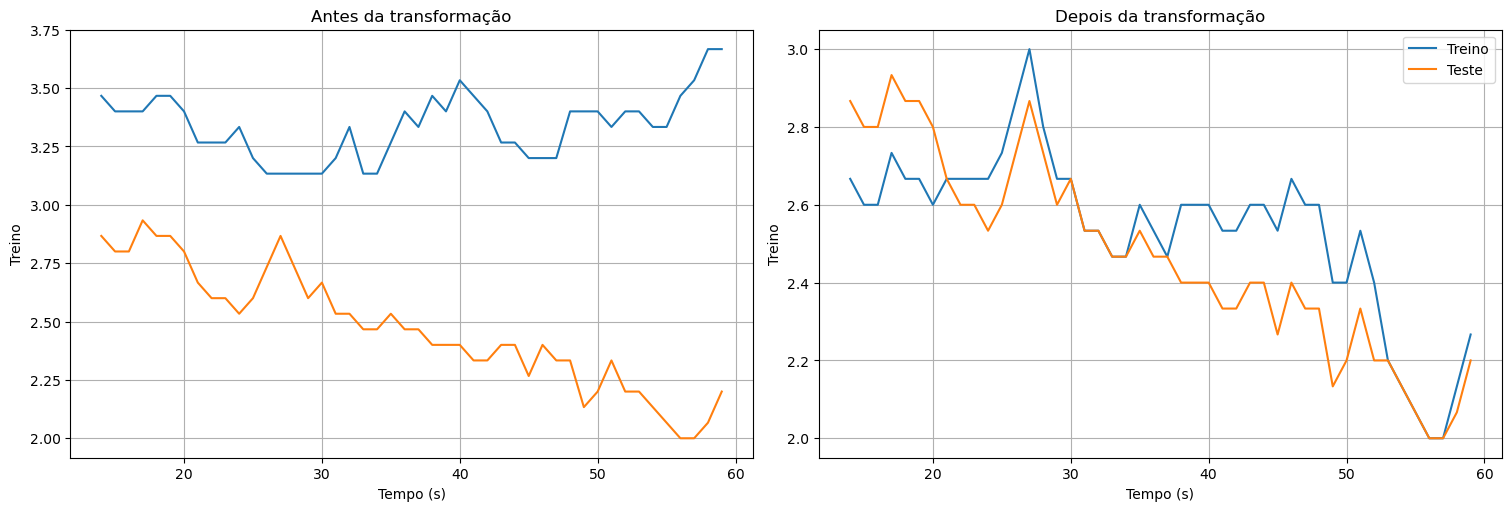

In [16]:
import matplotlib.pyplot as plt

y1 = y_hat  # depois da transformação
y2 = y_test  

z1 = y_hat_ #antes da transformação
z2 = y_test

#suavizar os dados do gráfico
window_size = 15
y1_smoothed = pd.Series(y1).rolling(window=window_size).mean()
y2_smoothed = pd.Series(y2).rolling(window=window_size).mean()
z1_smoothed = pd.Series(z1).rolling(window=window_size).mean()
z2_smoothed = pd.Series(z2).rolling(window=window_size).mean()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), layout='constrained')

# Conjunto de validação do classificador
axs[0].set_title('Antes da transformação')
axs[0].plot(z1_smoothed, label='Treino')
axs[0].plot(z2_smoothed, label='Teste')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Treino')
axs[0].grid(True)

# Conjunto de validação do meta-classificador
axs[1].set_title('Depois da transformação')
axs[1].plot(y1_smoothed, label='Treino')
axs[1].plot(y2_smoothed, label='Teste')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Treino')
axs[1].grid(True)

plt.legend()
plt.show()



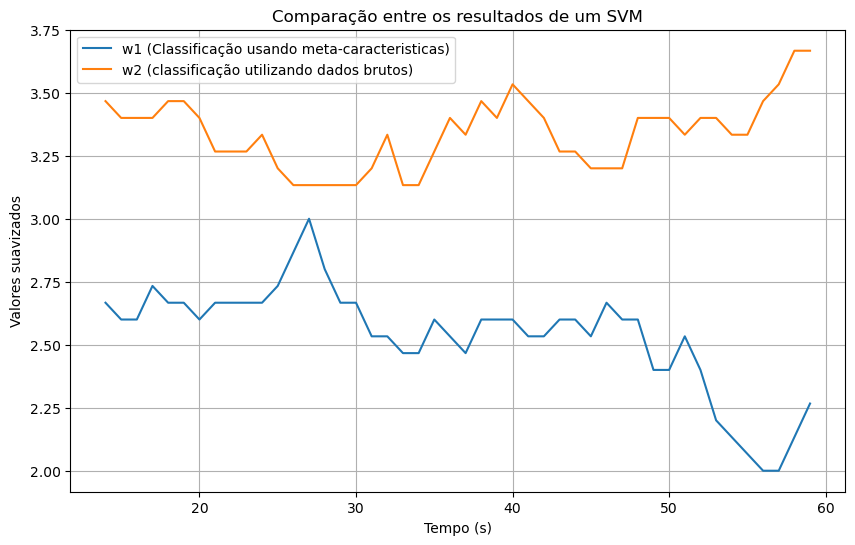

In [17]:
w1 = y_hat  # meta-classificador
w2 = y_hat_ #classificação

# Suavizar os dados do gráfico
window_size = 15
w1_smoothed = pd.Series(w1).rolling(window=window_size).mean()
w2_smoothed = pd.Series(w2).rolling(window=window_size).mean()

# Plotar os dados
plt.figure(figsize=(10, 6))
plt.plot(w1_smoothed, label='w1 (Classificação usando meta-caracteristicas)')
plt.plot(w2_smoothed, label='w2 (classificação utilizando dados brutos)')
plt.xlabel('Tempo (s)')
plt.ylabel('Valores suavizados')
plt.title('Comparação entre os resultados de um SVM')
plt.legend()
plt.grid(True)
plt.show()


### Treino em loop de todas as opções de classificadores disponiveis no Select Model.

In [18]:
algos = ['1nn', '3nn', 'svm', 'nb', 'gbc', 'ee', 'shape', 'rf', 'rd']
for algo in algos:
    
    print(f'Meta-classificador com modelo extrator {algo.upper()}')
    
    # Training
    try:
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option=algo)
        # Testing
        predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        
        print(f'Acurácia do teste usando o meta-classificador com modelo extrator {algo}: {test_accuracy_meta}')
    except Exception as e:
        print(f"Ocorreu um erro no teste com o {algo}: {e}")
    print("-------------------------------")

Meta-classificador com modelo extrator 1NN


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 208.38it/s]


Acurácia do teste usando o meta-classificador com modelo extrator 1nn: 0.8666666666666667
-------------------------------
Meta-classificador com modelo extrator 3NN


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 199.61it/s]


Acurácia do teste usando o meta-classificador com modelo extrator 3nn: 0.75
-------------------------------
Meta-classificador com modelo extrator SVM


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 208.25it/s]


Acurácia do teste usando o meta-classificador com modelo extrator svm: 0.8666666666666667
-------------------------------
Meta-classificador com modelo extrator NB


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 200.95it/s]


Acurácia do teste usando o meta-classificador com modelo extrator nb: 0.7833333333333333
-------------------------------
Meta-classificador com modelo extrator GBC


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 182.61it/s]


Acurácia do teste usando o meta-classificador com modelo extrator gbc: 0.85
-------------------------------
Meta-classificador com modelo extrator EE


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 130.32it/s]


Acurácia do teste usando o meta-classificador com modelo extrator ee: 0.8333333333333334
-------------------------------
Meta-classificador com modelo extrator SHAPE


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 107.90it/s]


Acurácia do teste usando o meta-classificador com modelo extrator shape: 0.8666666666666667
-------------------------------
Meta-classificador com modelo extrator RF


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 31.56it/s]


Acurácia do teste usando o meta-classificador com modelo extrator rf: 0.8666666666666667
-------------------------------
Meta-classificador com modelo extrator RD


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 201.71it/s]

Acurácia do teste usando o meta-classificador com modelo extrator rd: 0.8333333333333334
-------------------------------
